In [16]:
# -*- coding: utf-8 -*-
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import cv2
from scipy.cluster.vq import vq, kmeans
from matplotlib import pyplot as plt
import numpy as np
import time as t
import os
import math
import pandas as pd

In [3]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(30,30), ratio=1, conv_color = False):
    
    if conv_color:
        list_of_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in list_of_images]
    
    num_img = len(list_of_images)
    row = math.ceil( num_img / no_of_columns )
    
    if figsize[1] == 0:
        fig = plt.figure(figsize=(figsize[0], figsize[0]*row/no_of_columns/ratio))
    else:
        fig = plt.figure(figsize=figsize)
    
    for i, img in enumerate(list_of_images):
        fig.add_subplot( row, no_of_columns , i+1)
        plt.imshow(list_of_images[i])
        plt.axis('off')
    plt.show()
        

In [18]:
# set target organ
target_organ = 'cheek_l'

folder_color = {'black':'./augmented_data/face_black/',
               'blue':'./augmented_data/face_blue/',
               'yellow':'./augmented_data/face_yellow/',
               'white':'./augmented_data/face_white/',
               'red':'./augmented_data/face_red/',
               }

organ_dirs = {'jaw':'jaw/', 
              'cheek_l':'cheek_l/', 
              'cheek_r':'cheek_r/', 
              'nose':'nose/', 
              'lip':'lip/', 
              'forehead':'forehead/', 
              'neck':'neck/'
             }

file_paths = {}
for color in folder_color:
    file_paths[color] = []
    dir_color_organ = folder_color[color] + organ_dirs[target_organ]
    for file_name in os.listdir(dir_color_organ):
        file_paths[color].append(dir_color_organ + file_name)

for color in folder_color: 
    print (color)
    print (len(file_paths[color]))


black
188
blue
188
yellow
188
white
188
red
188


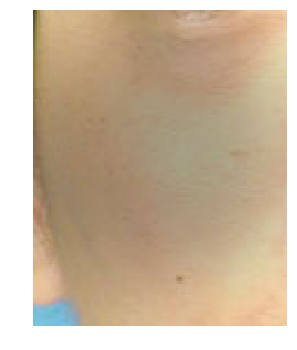

In [12]:
target_image = file_paths['black'][0]
img = cv2.imread(target_image)
# img[:,:,0] = np.zeros(img[:,:,1].shape)
# img[:,:,1] = np.zeros(img[:,:,2].shape)

# Img2Grey
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Grey2Binary
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# detect contour
_, contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
# draw contour
# cv2.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset ]]]]])
# cv2.drawContours(img, contours, 1, (0, 0, 255), 1)
images = [ img ]    
grid_display(images, contours, 2, (10,10), 2, conv_color = True)


### Use HSV space feature

In [13]:
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]

# plt.figure(figsize=(10,8))
# plt.subplot(311)                             #plot in the first cell
# plt.subplots_adjust(hspace=.5)
# plt.title("Hue")
# plt.hist(np.ndarray.flatten(hue), bins=235)
# plt.subplot(312)                             #plot in the second cell
# plt.title("Saturation")
# plt.hist(np.ndarray.flatten(sat), bins=200)
# plt.subplot(313)                             #plot in the third cell
# plt.title("Luminosity Value")
# plt.hist(np.ndarray.flatten(val), bins=200)
# plt.show()

In [86]:
#set feature dimension, e.g.  histogram bin number
dim_h = 180
dim_s = 256
dim_v = 256
hsv_data = np.zeros( ( len(file_paths['black'])*5, dim_h+dim_s+dim_v  ) )

fp = open('./data/hsv_'+target_organ+'.csv','w',encoding='utf-8')
fp.write( 'color,path,'+','.join([str(i) for i in range(dim_h+dim_s+dim_v)]) +'\r\n' )

for color in file_paths:
    for i, target_organ_path in enumerate( file_paths[color] ):
        img = cv2.imread(target_organ_path)
        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # hue(色调): 0-180
        # Saturation(饱和度): 0-255
        # Value(亮度): 0-255
        hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]
        # minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(val)
        # print('maxval: {}, minval:{}'.format(maxVal, minVal))
        label = np.array([[color]])
        hist_hue = cv2.calcHist([hsv_image], [0], None, [dim_h], [0, 180])
        hist_sat = cv2.calcHist([hsv_image], [1], None, [dim_s], [0, 256])
        hist_val = cv2.calcHist([hsv_image], [2], None, [dim_v], [0, 256])
        
        hsv_data[i] = np.ndarray.flatten(np.concatenate([hist_hue, hist_sat, hist_val]))
        # write row in csv
        csv_row = ','.join([color, target_organ_path]+[str(i) for i in hsv_data[i]])+'\r\n'
        fp.write(csv_row)
        
print ( csv_row[:100] )
print (hsv_data.shape)

fp.close()


red,./augmented_data/face_red/cheek_l/m-036-01.jpg,6.0,0.0,1.0,2.0,0.0,8.0,386.0,1322.0,2661.0,1988.
(940, 692)


### Use RGB space feature

In [89]:
dim = 256

# hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
print (img.shape)
hist_b = cv2.calcHist([img], [0], None, [dim], [0, 256])
hist_g = cv2.calcHist([img], [1], None, [dim], [0, 256])
hist_r = cv2.calcHist([img], [2], None, [dim], [0, 256])

# plt.figure(figsize=(10,8))
# plt.subplot(311)                             #plot in the first cell
# plt.subplots_adjust(hspace=.5)
# plt.title("blue")
# plt.bar(range(dim), hist_b, color = 'b')
# plt.subplot(312)                             #plot in the second cell
# plt.title("green")
# plt.bar(range(dim), hist_g, color = 'g')
# plt.subplot(313)                             #plot in the third cell
# plt.title("red")
# plt.bar(range(dim), hist_r, color = 'r')
# plt.show()

# plt.figure(figsize=(10,8))
# plt.subplot(311)                             #plot in the first cell
# plt.subplots_adjust(hspace=.5)
# plt.title("blue")
# plt.hist(np.ndarray.flatten(blue), bins=128)
# plt.subplot(312)                             #plot in the second cell
# plt.title("green")
# plt.hist(np.ndarray.flatten(green), bins=128)
# plt.subplot(313)                             #plot in the third cell
# plt.title("red")
# plt.hist(np.ndarray.flatten(red), bins=128)
# plt.show()

(119, 113, 3)


In [220]:
print (hist_g.shape)
print (np.ndarray.flatten(hist_b).shape)
concat_bgr = []
concat_bgr = np.concatenate([hist_b, hist_g, hist_r])
print (concat_bgr.shape)


(256, 1)
(256,)
(768, 1)


In [97]:
bgr_data = np.zeros( ( len(file_paths['black'])*5, dim*3  ) )

fp = open('./data/bgr_'+target_organ+'.csv','w',encoding='utf-8')
fp.write( 'color,path,'+','.join([str(i) for i in range(dim*3)]) +'\r\n' )

for color in file_paths:
    for i, target_organ_path in enumerate( file_paths[color] ):
        img = cv2.imread(target_organ_path)
        blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
        # normailize
    #     img[:,:,0] = blue/256
    #     img[:,:,1] = green/256
    #     img[:,:,2] = red/256
        hist_b = cv2.calcHist([img], [0], None, [dim], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [dim], [0, 256])
        hist_r = cv2.calcHist([img], [2], None, [dim], [0, 256])

        bgr_data[i] = np.ndarray.flatten(np.concatenate([hist_b, hist_g, hist_r]))
        # write row in csv
        csv_row = ','.join([color, target_organ_path]+[str(i) for i in bgr_data[i]])+'\r\n'
        fp.write(csv_row)
        
print ( csv_row[:100] )
print (bgr_data.shape)

fp.close()

red,./augmented_data/face_red/cheek_l/m-036-01.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,3
(940, 768)


### Kmeans Clustering

In [101]:
# tbl = pd.read_csv('./data/hsv_'+target_organ+'.csv')
tbl = pd.read_csv('./data/bgr_'+target_organ+'.csv')
sample_label = tbl["color"]
sample_path = tbl["path"]
# cluster_data = bgr_data
cluster_data = np.array(tbl.iloc[1:,2:])

print ( cluster_data[:5] )

[[ 0.  0.  0. ...,  0.  2.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [102]:
#set cluster number
cluster_num = 5

#use kmeans to cluster
clf = KMeans(n_clusters=cluster_num)
s = clf.fit(cluster_data)
print (s)
print (cluster_data.shape)

# #show center value
# print (clf.cluster_centers_)

# #show clusters
# print (clf.labels_)

# inertia_: Sum of squared distances of samples to their closest cluster center
# evaluate cluster inertia is good or not
# the value is better to be smaller, try different k and use the best one
print (clf.inertia_)

#predict
cluster_pred = clf.predict(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
(939, 768)
3025484525.51


3025484525.51
cluster: 0


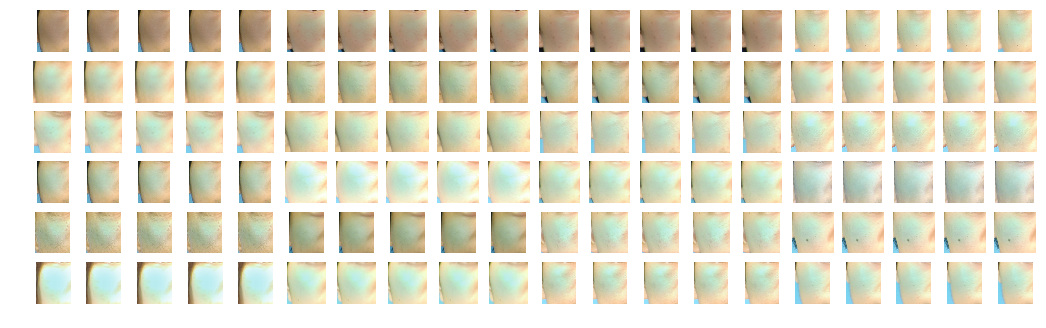

cluster: 1


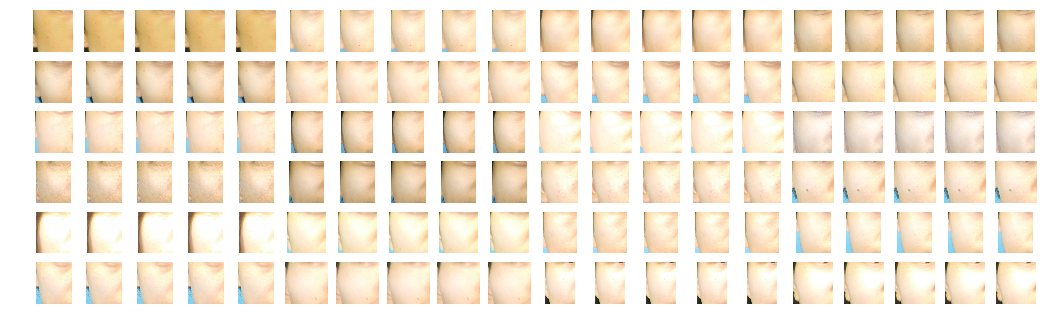

cluster: 2


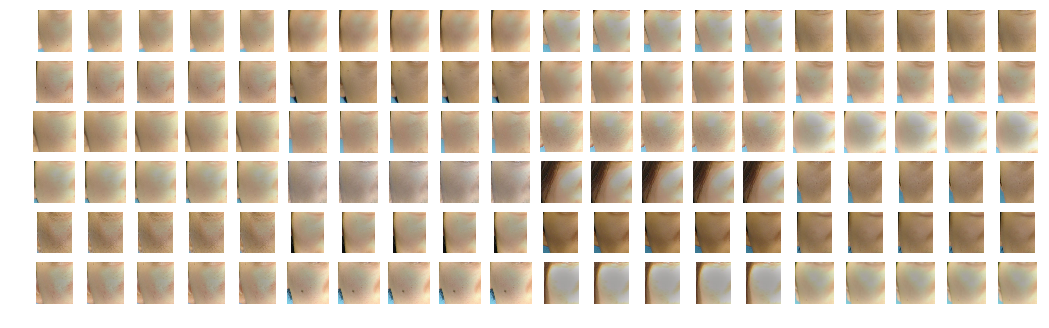

cluster: 3


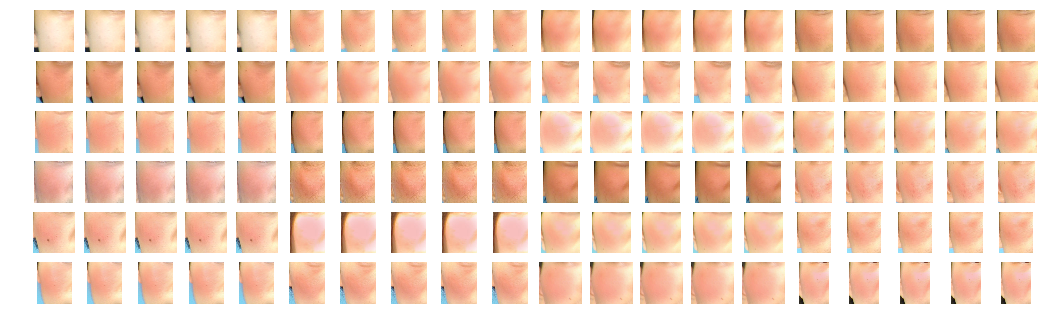

cluster: 4


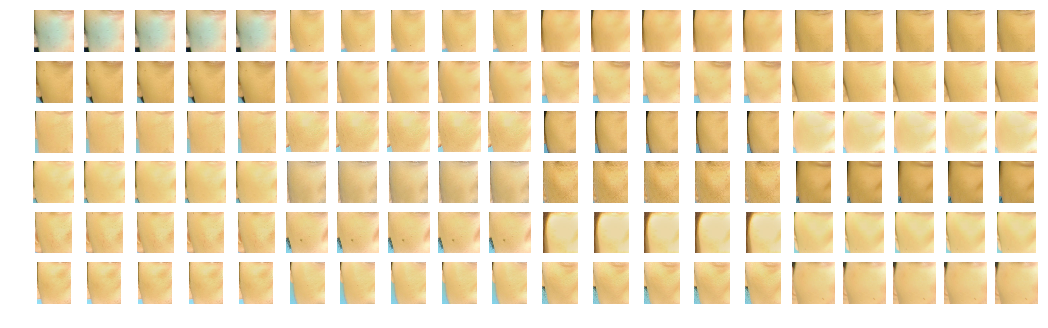

In [103]:
#store cluster result
clustered_imgs = {i:[] for i in range(cluster_num)}

for i, label in enumerate(cluster_pred):
    for color in file_paths:
        if len(clustered_imgs[label]) < 120:
            clustered_imgs[label].append( cv2.imread(sample_path[i]) ) 

print (clf.inertia_)
    
for key in clustered_imgs:
    print ('cluster: {}'.format(key))
    grid_display(clustered_imgs[key], [], 20, (18,0), 1, conv_color = True)

### LinearSVC classification

In [125]:
from sklearn import cross_validation, svm, metrics

# tbl = pd.read_csv('./data/hsv_'+target_organ+'.csv')
tbl = pd.read_csv('./data/bgr_'+target_organ+'.csv')
sample_label = tbl["color"][1:]
sample_path = tbl["path"]
# cluster_data = bgr_data
sample_data = tbl.iloc[1:,2:]

print ( sample_label[:5] )
print (sample_label.shape)

1    black
2    black
3    black
4    black
5    black
Name: color, dtype: object
(939,)


In [128]:
data_train, data_test, label_train, label_test = cross_validation.train_test_split(sample_data,sample_label)

clf = svm.LinearSVC()
clf.fit(data_train, label_train)

predict = clf.predict(data_test)

ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print(ac_score)
print(cl_report)
# print(tbl.head[:5])
print (predict[:5])

0.978723404255
             precision    recall  f1-score   support

      black       0.97      1.00      0.99        38
       blue       1.00      0.98      0.99        49
        red       0.96      1.00      0.98        51
      white       0.97      0.93      0.95        42
     yellow       0.98      0.98      0.98        55

avg / total       0.98      0.98      0.98       235

['red' 'white' 'yellow' 'yellow' 'black']


In [ ]:
#store cluster result
clustered_imgs = {i:[] for i in range(cluster_num)}

for i, label in enumerate(cluster_pred):
    for color in file_paths:
        if len(clustered_imgs[label]) < 60:
            clustered_imgs[label].append( cv2.imread(sample_path[i]) )

print (clf.inertia_)
    
for key in clustered_imgs:
    print ('cluster: {}'.format(key))
    grid_display(clustered_imgs[key], [], 20, (18,0), 1, conv_color = True)